In [1]:
import sys
sys.path.append('..')  # Add the parent directory to sys.path

In [2]:
import time, os, torch
import numpy as np
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from src.utils import train, compute_accuracy, set_device, plot_performance_over_time, plot_training_times
from src.models import SimpleMLP, AttentionMLP, ConjugationRNN

In [3]:
SEED = 265
torch.manual_seed(SEED)
DEVICE = set_device("cuda")
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
PATH_GENERATED = "../generated_data/"
data_train = torch.load(PATH_GENERATED + "data_train.pt")
data_val = torch.load(PATH_GENERATED + "data_val.pt")
data_test = torch.load(PATH_GENERATED + "data_test.pt")
mapping = torch.load(PATH_GENERATED + "mapping.pt")
embedding = torch.load(PATH_GENERATED + "embedding_matrix.pt")
vocab = torch.load(PATH_GENERATED + "vocabulary.pt")

In [5]:
datasets = [data_train, data_val, data_test]
target_filter  = ["be", "am", "are", "is", "was", "were", "been", "being", "have", "has", "had", "having"]
target_map = {vocab[w]: i for i, w in enumerate(target_filter)}

if os.path.isfile(PATH_GENERATED + "conjugation_data.pt"):
    datasets = torch.load(PATH_GENERATED + "conjugation_data.pt")
else:
    for i, dataset in enumerate(datasets):
        filtered_tensors = []
        for context, target in dataset:
            if mapping[int(target)] in target_filter:
                filtered_tensors.append((context, torch.tensor(target_map[int(target)])))
        filtered_tensors = list(zip(*filtered_tensors))
        filtered_tensors = TensorDataset(*[torch.stack(t) for t in filtered_tensors])
        datasets[i] = filtered_tensors

In [6]:
data_train, data_val, data_test = datasets
print("Size of training data: ", len(data_train))
print("Size of validation data: ", len(data_val))
print("Size of test data: ", len(data_test))

Size of training data:  124030
Size of validation data:  2590
Size of test data:  4765


In [7]:
context_size = int(data_train[0][0].shape[0])
batch_size = 64
n_epochs = 30
loss_fn = nn.CrossEntropyLoss()

print(f"-- Global Parameters --")
print(f"{batch_size=}")
print(f"{n_epochs=}")
print(f"{context_size=}") 

model_architectures = [SimpleMLP, AttentionMLP, ConjugationRNN]
# Each model parameter corresponds to the architecture at the same position
model_parameters = [
    [
        {"l1": 128, "l2": 32},
        {"l1": 256, "l2": 64},
        {"l1": 256, "l2": 256},
    ],
    [
        {"n_heads": 4, "w_size": 8},
        {"n_heads": 8, "w_size": 16},
        {"n_heads": 16, "w_size": 20},
    ],
    [
        {"num_hiddens": 8, "num_layers": 4, "dropout": 0},   
        {"num_hiddens": 16, "num_layers": 8, "dropout": 0.1},   
        {"num_hiddens": 20, "num_layers": 16, "dropout": 0.01},   
    ]
]
parameter_search = [
    {"lr":0.008},
    {"lr":0.001},
    {"lr":0.0005},
]

-- Global Parameters --
batch_size=64
n_epochs=30
context_size=12


In [8]:
train_loader = DataLoader(data_train, batch_size=batch_size)
val_loader = DataLoader(data_val, batch_size=batch_size)

In [9]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
val_perfs = []
models = []
architecture_times = []

if os.path.isfile(PATH_GENERATED + "conjugation_model.pt"):
    print("Skipping training, loading existing model...")
else:
    for architecture, m_params in zip(model_architectures, model_parameters):
        model_times = []
        for params in parameter_search:
            print("\n-- Training with following parameters --:")
            print("\nModel architecture: ", architecture)
            for name, val in params.items():
                print(f"{name}: {val}")
            for m_param in m_params:
                print(m_param)
                
                embedding = embedding.to(DEVICE)
                torch.manual_seed(SEED)
                model = architecture(embedding, max_len=context_size, **m_param)
                model.to(DEVICE)
                optimizer = Adam(model.parameters(), lr=params["lr"])
    
                start_time = time.time()
                train_loss, val_loss, train_acc, val_acc = train(n_epochs, model, optimizer, loss_fn, train_loader, val_loader, DEVICE)
                end_time = time.time()
                training_time = end_time-start_time
                model_times.append(training_time)
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                train_accs.append(train_acc)
                val_accs.append(val_acc)
                val_perfs.append(val_acc[-1])
                models.append(model)
                print(f"Training time: {training_time:.3f}s")
                print(f"Train accuracy: {train_acc[-1]*100:.3f}%")
                print(f"Validation accuracy: {val_acc[-1]*100:.3f}%\n")
        architecture_times.append(np.average(model_times))
            


-- Training with following parameters --:

Model architecture:  <class 'src.models.SimpleMLP'>
lr: 0.008
{'l1': 128, 'l2': 32}
20:37:17.620821, Epoch: 1, train_loss: 1.270, train_accuracy: 50.589%, val_loss: 1.277, val_accuracy: 54.247%
20:37:35.213755, Epoch: 10, train_loss: 1.030, train_accuracy: 55.660%, val_loss: 1.260, val_accuracy: 56.834%
20:37:58.711457, Epoch: 20, train_loss: 0.990, train_accuracy: 57.284%, val_loss: 1.291, val_accuracy: 57.143%
20:38:22.279815, Epoch: 30, train_loss: 0.969, train_accuracy: 57.541%, val_loss: 1.388, val_accuracy: 56.988%
Training time: 66.996s
Train accuracy: 57.541%
Validation accuracy: 56.988%

{'l1': 256, 'l2': 64}
20:38:24.851939, Epoch: 1, train_loss: 1.268, train_accuracy: 50.262%, val_loss: 1.307, val_accuracy: 53.707%
20:38:44.716238, Epoch: 10, train_loss: 1.008, train_accuracy: 56.822%, val_loss: 1.320, val_accuracy: 55.946%
20:39:06.939330, Epoch: 20, train_loss: 0.948, train_accuracy: 57.555%, val_loss: 1.473, val_accuracy: 56.216

In [10]:
if os.path.isfile(PATH_GENERATED + "conjugation_model.pt"):
    chosen_model = torch.load(PATH_GENERATED + "conjugation_model.pt")
    chosen_index, architecture_times, train_losses, val_losses, train_accs, val_accs = torch.load(PATH_GENERATED + "conjugation_plots.pt")
else:
    chosen_index = val_perfs.index(max(val_perfs))
    chosen_model = models[chosen_index]
    torch.save(chosen_model, PATH_GENERATED + "conjugation_model.pt")
    torch.save((chosen_index, architecture_times, train_losses, val_losses, train_accs, val_accs), PATH_GENERATED + "conjugation_plots.pt")
print(chosen_model)

AttentionMLP(
  (embedding): Embedding(1880, 16)
  (positional_encoding): PositionalEncoding()
  (multi_head): MultiHeadLayer(
    (attention_heads): ModuleList(
      (0-15): 16 x SingleHead(
        (query): Linear(in_features=16, out_features=20, bias=True)
        (key): Linear(in_features=16, out_features=20, bias=True)
        (value): Linear(in_features=16, out_features=20, bias=True)
        (scaled_dot_product_attention): ScaledDotProductAttention()
      )
    )
    (attention_out): Linear(in_features=320, out_features=16, bias=True)
  )
  (fc1): Linear(in_features=192, out_features=12, bias=True)
)


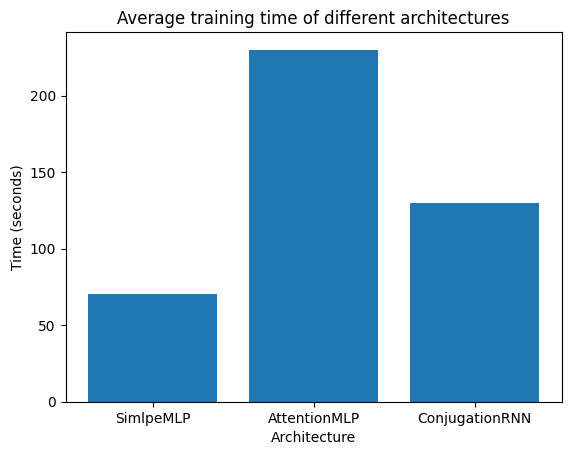

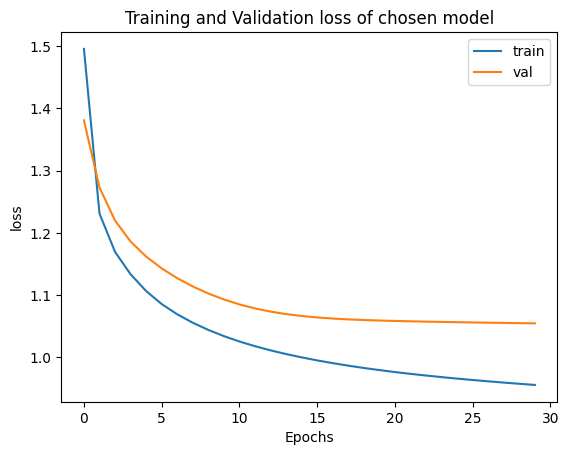

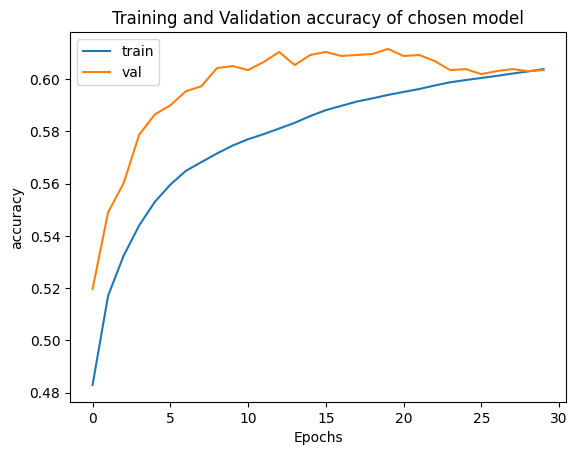

In [11]:
plot_training_times(architecture_times, ["SimlpeMLP", "AttentionMLP", "ConjugationRNN"],
                    f_name="../images/conjugation_training_times.png", save=True)
plot_performance_over_time(train_losses[chosen_index], val_losses[chosen_index],
                           "Training and Validation loss of chosen model", "loss",
                            f_name="../images/conjugation_loss.png", save=True)
plot_performance_over_time(train_accs[chosen_index], val_accs[chosen_index],
                           "Training and Validation accuracy of chosen model", "accuracy",
                            f_name="../images/conjugation_accuracy.png", save=True)

In [12]:
test_loader = DataLoader(data_test, batch_size=batch_size)

In [13]:
test_acc = compute_accuracy(chosen_model, test_loader, device=DEVICE)
print(f"Test accuracy: {test_acc*100:.3f}%")

Test accuracy: 54.397%
